In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from skimage import io as skio
import datasetdatabase as dsdb
from aicsfeature.extractor import cell, dna, structure
from aicsimage import io, processing
import matplotlib.pyplot as plt

os.environ["DSDB_PROCESS_LIMIT"] = "16"

### Load metadata

In [2]:
with open('../../data-raw/QCB_drug_cell_meta.pkl', 'rb') as fp:
    df_meta = pickle.load(fp)
df_meta.shape

(1519, 8)

In [3]:
df_meta.columns

Index(['cell_id', 'cell_ver', 'czi_filename', 'drug_label', 'idx_in_stack',
       'roi', 'str_ver', 'structure_name'],
      dtype='object')

### Available structures

In [4]:
df_meta['structure_name'].unique()

array(['tubulin', 'sec61b', 'beta-actin', 'golgi', 'zo1', 'myosin',
       'lamp1'], dtype=object)

### Subset of meta for which the structure of interest is available

In [5]:
df_meta_str = df_meta.loc[df_meta.structure_name=='TOM20']
df_meta_str = df_meta_str.reset_index(drop=True)
df_meta_str.shape

(900, 11)

### Display structure for a few cells

In [6]:
rootf = '/allen/aics/assay-dev/Analysis/QCB_database/cell_info'

/allen/aics/assay-dev/Analysis/QCB_database/cell_info/611b2011-36af-490f-8379-0eebbc10ed1c/seg.ome.tif
seg (3, 116, 211, 194) raw (3, 116, 211, 194)


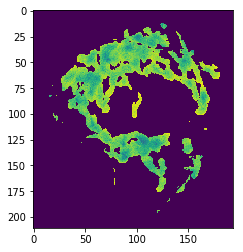

   dna_volume  dna_surface_area  dna_1st_axis_x  dna_1st_axis_y  \
0      115785             52597        0.432338        0.872597   

   dna_1st_axis_z  dna_2nd_axis_x  dna_2nd_axis_y  dna_2nd_axis_z  \
0       -0.227285         0.89389       -0.447877       -0.019155   

   dna_3rd_axis_x  dna_3rd_axis_y           ...             \
0         0.11851        0.194887           ...              

   dna_haralick_variance  dna_haralick_inv_diff_moment  dna_haralick_sum_avg  \
0             490.503014                      0.094984             403.86127   

   dna_haralick_sum_var  dna_haralick_sum_entropy  dna_haralick_entropy  \
0           1726.917702                  7.294647             11.245728   

   dna_haralick_diff_var  dna_haralick_diff_entropy  dna_haralick_info_corr1  \
0                0.00014                   4.958488                 -0.11373   

   dna_haralick_info_corr2  
0                 0.847879  

[1 rows x 45 columns]


In [8]:
cids = np.random.randint(df_meta_str.shape[0], size=1)
cids = [0]
for cid in cids:
    seg_path = os.path.join(rootf,df_meta_str.cell_id[cid],'seg.ome.tif')
    raw_path = os.path.join(rootf,df_meta_str.cell_id[cid],'raw.ome.tif')
    print(seg_path)
    SEG = skio.imread(seg_path)
    RAW = skio.imread(raw_path)
    print('seg',SEG.shape,'raw',RAW.shape)
    plt.imshow(np.max(RAW[2,:,:,:],axis=0)*np.max(SEG[2,:,:,:],axis=0)) # channels: 0-dna, 1-mem
    plt.show()
    
#df = structure.get_features(img=RAW[2,:,:,:]*SEG[2,:,:,:], extra_features=["intensity","network"])
df = dna.get_features(img=RAW[2,:,:,:]*SEG[2,:,:,:])
print(df.head())

In [ ]:
df.shape

In [ ]:
print(RAW.dtype)
img_original = RAW[2,:,:,:]*SEG[2,:,:,:]
img_enhanced = np.copy(img_original)
print(img_enhanced.max())
qtl = np.percentile(img_enhanced[img_enhanced>0],99.99)
print(qtl)
img_enhanced = img_enhanced.clip(0,qtl)
img_enhanced = ((255./qtl)*img_enhanced).astype(np.uint8)
plt.imshow(img_enhanced.max(axis=0))

In [ ]:
from skimage.measure import label, regionprops
regions = label(img_original>0)
for i in range(1,regions.max()+1):
    print(i,(regions==i).sum())

In [ ]:
for i in range(1,27):
    df = structure.get_features((regions==i)*RAW[2,:,:,:], extra_features=["texture"])
    print(i,df.str_volume_mean,df.str_haralick_corr_mean)

In [ ]:
from itkwidgets import view
view((regions==14)*RAW[2,:,:,:])

# Debugging section

In [ ]:
from skimage.measure import label, regionprops
seg = SEG[2,:,:,:]
seg[seg>0] = 1
regions = label(seg)

In [ ]:
regions.max()

In [ ]:
skel = skeletonize_3d(regions.astype(np.uint8))

In [ ]:
from skimage.morphology import skeletonize_3d
for i in range(1,regions.max()+1):
    comp=np.copy(regions)
    comp[comp!=i] = 0

    skel = skeletonize_3d(comp.astype(np.uint8))

    skel[skel>0] = 1

    skel = np.pad(skel,1,'constant')

    skel_degree = np.copy(skel)

    z_pxl, y_pxl, x_pxl = np.where(skel>0)

    nv = len(z_pxl)

    for  x, y, z in zip(x_pxl,y_pxl,z_pxl):
        neigh = skel[z-1:z+2,y-1:y+2,x-1:x+2]
        skel_degree[z,y,x] = neigh.sum()

    nt = skel.sum()
    n0 = np.sum(skel_degree==(0+1))
    n1 = np.sum(skel_degree==(1+1))
    n2 = np.sum(skel_degree==(2+1))
    n3 = np.sum(skel_degree==(3+1))
    n4 = np.sum(skel_degree>=(4+1))
    
    x = np.nan if nv==0 else nt if n2==nt else 1 if n0==1 else 2.0*nt / (n1+3*n3+4*n4)
    
    print(nv,nt,n0,x)

In [ ]:
q=np.random.randint(2,size=50**3).reshape(50,50,50)
s=skeletonize_3d(q.astype(np.uint8))
s.max()

In [ ]:
plt.imshow(s[25,:,:]) # channels: 0-dna, 1-mem
plt.show()

In [ ]:
np.bincount(q.reshape(-1))

In [ ]:
with open('tmp_str_tubulin_drug_ds.pkl', 'rb') as fp:
    df = pickle.load(fp)
df.head()

In [ ]:
df.str_

# Debugging uploaded datasets

In [2]:
import datasetdatabase as dsdb
prod = dsdb.DatasetDatabase(config='/allen/aics/assay-dev/Analysis/QCB_database/prod_config.json')

In [ ]:
df_mem = prod.get_dataset(name="QCB_DRUG_MEM_feature")

In [ ]:
df_dna = prod.get_dataset(name="QCB_DNA_feature")

In [ ]:
df_st6 = prod.get_dataset(name="QCB_DRUG_ST6GAL_feature")

In [ ]:
df_tom = prod.get_dataset(name="QCB_TOM20_feature")

In [ ]:
df_mem.ds.head()

In [ ]:
df_dna.ds.head()

In [ ]:
df_st6.ds.head()

In [ ]:
df_tom.ds.head()

In [ ]:
with open('../../data-raw/QCB_DRUG_MEM_feature.pkl', 'rb') as fp:
    df_mem = pickle.load(fp)

In [ ]:
df_mem.head()

In [ ]:
with open('../../data-raw/QCB_DRUG_DNA_feature.pkl', 'rb') as fp:
    df_dna = pickle.load(fp)
df_dna.head()

In [ ]:
df_st6.ds.columns.values

In [3]:
df_sec = prod.get_dataset(name="QCB_DRUG_SEC61B_feature")

Reconstructing dataset...
[============================================================] 100.0% 107/107 ~ 0:0:0 remaining


In [4]:
df_sec.ds.shape

(107, 167)